# Определение стоимости автомобилей

### Введение

**Цель проекта**: построение модели для определения рыночной стоимости автомобилей с пробегом.

**Входные данные** 

Информация об автомобилях (технические характеристики, комплектация и цены) находится в файле: `/datasets/autos.csv`


***Признаки***
- *DateCrawled* — дата скачивания анкеты из базы;
- *VehicleType* — тип автомобильного кузова;
- *RegistrationYear* — год регистрации автомобиля;
- *Gearbox* — тип коробки передач;
- *Power* — мощность (л. с.);
- *Model* — модель автомобиля;
- *Kilometer* — пробег (км);
- *RegistrationMonth* — месяц регистрации автомобиля;
- *FuelType* — тип топлива;
- *Brand* — марка автомобиля;
- *NotRepaired* — была машина в ремонте или нет;
- *DateCreated* — дата создания анкеты;
- *NumberOfPictures* — количество фотографий автомобиля;
- *PostalCode* — почтовый индекс владельца анкеты (пользователя);
- *LastSeen* — дата последней активности пользователя

***Целевой признак***
- *Price* — цена (евро)

## Подготовка данных

In [51]:
# Импортируем библиотеки, которые нам понадобятся в дальнейшем:
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy import stats as st
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from IPython.core.display import HTML
from datetime import datetime, timedelta
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor, CatBoost, cv
import warnings

# sklearn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor

Прочтем предоставленный файл и сохраним DataFrame в соответствующей переменной. Выведем и изучим общую информацию о полученных данных, проверим корректность названий столбцов, количество пропусков и дубликатов:

In [2]:
data_autos = pd.read_csv('/datasets/autos.csv')
data_autos.info()
print()
print(data_autos.columns)
print()
display(data_autos.head())
print()
print('Количество пропусков:')
print(data_autos.isna().sum())
print()
print('Количество дубликатов:', data_autos.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'Fue

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Количество пропусков:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Количество дубликатов: 4


Приведем наименования столбцов к удобному для работы формату (изменим на формат на snake case):

In [3]:
data_autos.set_axis(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
                     'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 
                     'brand', 'not_repaired', 'date_created', 'number_of_pictures', 
                     'postal_code', 'last_seen'], axis='columns', inplace=True)
print(data_autos.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


Устраним полные дубликаты, поскольку высока вероятность их возникновения в результате технических ошибок:

In [4]:
data_autos = data_autos.drop_duplicates().reset_index(drop=True)
print(data_autos.shape)

(354365, 16)


Рассмотрим пропуски и возможности их устранения

In [5]:
# Составим функцию для проверки уникальных и пропущенных значений:
def lost_data(data, column):
    print(column)
    print(data[column].unique())
    print(data[column].value_counts())
    print()

In [6]:
for i in data_autos.columns:
    lost_data(data_autos, i)

date_crawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-03-22 14:50:05    5
2016-03-22 10:42:10    5
                      ..
2016-03-15 18:49:27    1
2016-03-09 14:48:54    1
2016-03-22 16:25:17    1
2016-03-25 22:51:28    1
2016-03-20 18:47:46    1
Name: date_crawled, Length: 271174, dtype: int64

price
[  480 18300  9800 ... 12395 18429 10985]
0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13440        1
1414         1
8069         1
10370        1
384          1
Name: price, Length: 3731, dtype: int64

vehicle_type
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_ty

***Не требуют обработки***:  
- *'price'*: целевой признак. Имеются аномальные нулевые значения, которые можно объяснить тем, что владельцы отдают даром автомобили (вероятно битые и в короткие сроки. достаточно распространенная пркатика на Западе). Ввиду отсутствия дополнительной информации - оставляем без изменений;
- *'kilometer'*: пропущенных данных нет, значения адекватны;
- *'brand'*: пропущенных данных нет, значения адекватны;


***Требуют обработки***:  
- *'vehicle_type'*: имеются порядка 10% пропущенных значений, что достаточно много. Из-за невозможности уточнения информации и отсутствия источников для адекватной замены на имеющиеся группы, заполним пропуски категорией 'unknown';
- *'registration_year'*: пропусков нет. Имеются аномальные значения, например год регистрации 1111 или 5000. Поскольку это явная ошибка, возможно вызванная некорректным форматом введимых данных в соответствующее поле, либо техническим сбоем, исключим позиции, год регистрации для которых выходит за рамки интервала 1900-2021 гг;
- *'gearbox'*: имеются порядка 5,5% пропущенных значений, что достаточно много. Из-за невозможности уточнения информации и отсутствия источников для адекватной замены на имеющиеся группы, заполним пропуски категорией 'unknown';
- *'power'*: мощность двигателя не имеет пропущенных значений, однако явно выбиваются аномальные значения - как нулевые, так и сверхогромные более 3500 (максимальная на текущий момент мощность гоночного болида Nissan GT-R от Extreme Turbo Systems). Значений свыше 3500 - 89 шт., их можно удалить без ущерба. Пробема в нулевых значениях - их причина появления может быть вызвана множеством причин: от банального технического сбоя, до человеческого фактора - владельцы авто просто не заполнили данную информацию. Наиболее обосновано смотрится предположение о том, что двигатель в автомобиле просто отсутствует. В случае отсутствия возможности подтвердить или опровергнуть данное предположение, используем его для обоснование для нулевых значений, что позволит нам сохранить большой массив информации.
- *'model'*: имеются порядка 5,5% пропущенных значений, что достаточно много. С учетом того, что у нас есть полные данные о бренде автомобиля, мы можем использовать для пропусков модальные значения по каждой из соответствующих групп. 
- *'fuel_type'*: имеются порядка 10% пропущенных значений, что достаточно много. Из-за невозможности уточнения информации и отсутствия источников для адекватной замены на имеющиеся группы, заполним пропуски категорией 'unknown';
- *'not_repaired'*: самое большое число пропусков ~20%. Поскольку удаление такого числа негативно скажется на качестве обучения, будем исходить из того, что отсутствие данных подразумевает, что клиент не сделал соответствующую отметку о том, что машина была в ремонте, т.е. заменим пропуски значением "no";

***Не имеют предсказательной силы***:  
- *'date_crawled'*: пропущенных данных нет. Признак не имеет предсказательной силы, можно исключить.
- *'registration_month'*: имеются аномальные значения - количество категорий - 13, что нелогично. Признак имеет крайне низкую предсказательную силу, особенно с учетом наличия гораздо более информативного показателя 'registration_year'. Исключаем.
- *'date_created'*: пропущенных данных нет. Признак не имеет предсказательной силы, можно исключить.
- *'number_of_pictures'*: имеется только единственное значение. Пропущенных данных нет. Признак не имеет предсказательной силы, можно исключить.
- *'postal_code'*: пропущенных данных нет. Признак имеет очень слабую предсказательную силу, можно исключить.
- *'last_seen'*: пропущенных данных нет. Признак не имеет предсказательной силы, можно исключить.

In [7]:
# Исключаем признаки, которые не имеют предсказательной силы:
data_autos = data_autos.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 
                              'postal_code', 'last_seen'], axis=1)

In [12]:
# Избавляемся от аномальных значений:
data_autos = data_autos.query('(registration_year >= 1900) and (registration_year < 2021)').reset_index(drop=True)
data_autos = data_autos.query('power <= 3500').reset_index(drop=True)

In [13]:
# Заменяем пропуски модальными значениями:
model_grouped = data_autos.groupby('brand').agg(lambda x: x.mode(dropna=False)[0])['model']
display(model_grouped)

brand
alfa_romeo               156
audi                      a4
bmw                      3er
chevrolet              other
chrysler               other
citroen                other
dacia                  logan
daewoo                 matiz
daihatsu               cuore
fiat                   punto
ford                   focus
honda                  civic
hyundai              i_reihe
jaguar                 other
jeep                   grand
kia                    other
lada                    niva
lancia               ypsilon
land_rover        freelander
mazda                3_reihe
mercedes_benz       c_klasse
mini                  cooper
mitsubishi              colt
nissan                 micra
opel                   corsa
peugeot              2_reihe
porsche              cayenne
renault               twingo
rover                  other
saab                   other
seat                   ibiza
skoda                octavia
smart                 fortwo
sonstige_autos           NaN
subaru  

Для sonstige_autos модальным значением модели является "NaN". Поскольку данная формулировка предполагает прочие неперечисленные бренды, заполним обозначенные пропуски значением "other"

In [14]:
#Заполним пропуски модами соответствующих брендов:
data_autos['model'] = data_autos['model'].fillna(0)

def modas_model(row):
    model = row['model']
    brand = row['brand']
    if model == 0:
        return model_grouped[brand]
    return model

data_autos['model'] = data_autos.apply(modas_model, axis=1)

In [17]:
#display(data_autos)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,a4,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354101,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354102,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354103,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354104,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [18]:
# Заполняем пропуски значениями:
data_autos.loc[:, ['vehicle_type', 'gearbox', 'fuel_type']] = data_autos.loc[:, 
                                                                             ['vehicle_type', 'gearbox', 'fuel_type']].fillna('unknown')
data_autos['model'] = data_autos['model'].fillna('other')
data_autos['not_repaired'] = data_autos['not_repaired'].fillna('no')

In [19]:
# Проверим типы данных
print(data_autos.dtypes)

price                 int64
vehicle_type         object
registration_year     int64
gearbox              object
power                 int64
model                object
kilometer             int64
fuel_type            object
brand                object
not_repaired         object
dtype: object


Типы данных адекватны. 

Поскольку для обучения модели признаки не могут быть категориальными, преобразуем последние в численные: для ускорения процесса обучения используем технику OHE для 'vehicle_type', 'gearbox', 'fuel_type', 'not_repaired' (так как в них достаточно невысокое количество значений) и технику порядкового кодирования для 'model', 'brand' (использование OHE нецелесообразно из-за большого числа категорий, что значительно увеличит размер выборок).

In [20]:
# Выделим числовые признаки, признаки для OHE и для OrdinalEcoder:
numeric_columns = ['price', 'registration_year', 'power', 'kilometer']
ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'not_repaired']
ordinal_columns = ['model', 'brand']

# Порядковое кодирование:
encoder = OrdinalEncoder()
data_autos_ordinal = pd.DataFrame(encoder.fit_transform(data_autos.loc[:, ordinal_columns]),
                            columns=ordinal_columns)
data_autos_ordinal = data_autos_ordinal.astype('int')
display(data_autos_ordinal.head())
print(data_autos_ordinal.shape)

,model,brand
0,116,38
1,29,1
2,117,14
3,116,38
4,101,31


(354106, 2)


In [21]:
# OHE:
data_autos_ohe = pd.get_dummies(data_autos.loc[:, ohe_columns], drop_first=True)
display(data_autos_ohe.head())
print(data_autos_ohe.shape)

,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon,gearbox_manual,gearbox_unknown,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,not_repaired_yes
0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0


(354106, 18)


In [22]:
# Объединим полученные датафреймы в единый:
data_autos_final = data_autos[numeric_columns].join([data_autos_ordinal, data_autos_ohe])
display(data_autos_final.head())
print(data_autos_final.shape)

,price,registration_year,power,kilometer,model,brand,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,gearbox_manual,gearbox_unknown,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,not_repaired_yes
0,480,1993,0,150000,116,38,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,18300,2011,190,125000,29,1,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
2,9800,2004,163,125000,117,14,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1500,2001,75,150000,116,38,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,101,31,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


(354106, 24)


Проведем анализ количественных переменных.

In [23]:
for i in data_autos_final[numeric_columns].columns:
    #fig = go.Figure()
    #fig.add_trace(go.Box(y=data_autos_final[i], name=i))
    #fig.show()
    print(data_autos_final[i].describe())

count    354106.000000
mean       4417.971706
std        4514.251411
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64
count    354106.000000
mean       2003.084822
std           7.536140
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64
count    354106.000000
mean        107.532835
std          74.573773
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max        3500.000000
Name: power, dtype: float64
count    354106.000000
mean     128270.108386
std       37820.060383
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


'price': цена продажи авто колеблется в интервале от 0 до 20 тыс. евро. Медиана значительно меньше среднего значения (2.7 против 4.4 тыс. евро), что свидетельствует о положительной ассимметрии графика распределения и значительном влиянии аномально высоких значений цены (дороже 14.4 тыс. евро)
'registration_year': год регистрации автомобиля лежит в интервале 1910-2019 гг. Медианное значение практически соответствует среднему (2003 год), что свидетельствует о распределении, близком к нормальному. Машины, зарегистрированные ранее 1986 года достаточно редки.
'power': мощность двигателя автомобилей изменяется от 0 до 3500 л.с. Медиана близка к среднему значению (105 и 107.5 л.с. соответственно), что свидетельствует о распределении, близком к нормальному. Машины, с мощностью двигателя свыше 254 л.с. достаточно редки.
'kilometer': пробег автомобилей изменяется от 5 тыс. км. до 150 тыс. км. Медиана выше среднего значения (105 и 107.5 л.с. соответственно), что говорит нам о наличии отрицательной ассимметрии графика распределения и влияния аномально низких значений.

Рассмотрим данные признаки на наличие мультиколлинеарности, чтобы исключить утечку целевого признака.

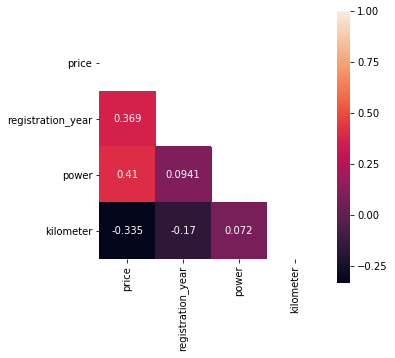

In [24]:
# Выведем матрицу корреляции для датафрейма, предварительно создав соответствующую 
# функцию, исключив столбцы с качественными переменными:

matrix = np.triu(data_autos_final.loc[:, numeric_columns].corr())
plt.figure(figsize=(5,5))
sns.heatmap(data_autos_final.loc[:, numeric_columns].corr(), annot=True, mask=matrix, fmt='.3g', square=True)
plt.show()

Коэффициенты коррелляции не превышают значения 0.41 по абсолютному значению, что говорит об отсутствии мультиколлинеарности между признаками.  

Разобьем итоговый датафрейм на обучающую и валидационную выборки в соотношении 75:25, после чего проведем масштабирование количественных признаков.

In [25]:
# Для стандартизации признаков предварительно разделим набор данных на выборки
# В соответствии с условиями задачи - обучающая и валидационная в соотношении 75:25

features = data_autos_final.drop('price', axis=1)
target = data_autos_final['price']
print(features.shape, target.shape)

r=42


features_train, features_valid, target_train, target_valid = train_test_split(features, target,  
                                            test_size=0.25, random_state=r)

print(features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)

(354106, 23) (354106,)
(265579, 23) (88527, 23) (265579,) (88527,)


In [26]:
features_numeric_columns = numeric_columns[1:4]
print(features_numeric_columns)

['registration_year', 'power', 'kilometer']


In [27]:
# Масштабируем признаки
pd.options.mode.chained_assignment = None  # убираем предупреждение
scaler=StandardScaler()
scaler.fit(features_train[features_numeric_columns])
features_train.loc[:, features_numeric_columns] = scaler.transform(features_train.
                                                                   loc[:, features_numeric_columns])
features_valid.loc[:, features_numeric_columns] = scaler.transform(features_valid.
                                                                   loc[:, features_numeric_columns])

**Вывод**  

Мы подготовили данные для обучения модели: провели кодирование, масштабирование, разделение выборок.

## Обучение моделей

После проведения подготовки признаков, обучим, проанализируем скорость работы и оценим качество различных моделей, используя метрику RMSE. 
Для начала рассмотрим простые модели линейной регрессии, дерева решений и случайного леса, после чего применим градиентный бустинг с использованием библиотек LightGBM и Catboost.

### Модели дерева решений, линейной регрессии и случайного леса

In [58]:
r=42 #random_state

# Создадим функцию для поиска лучших параметров модели при помощи GrindSearch:
def grind_simple_model(model, params):
    grind_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5, verbose=10)  
    return grind_model
warnings.filterwarnings("ignore")

- *Дерево решений:*

In [29]:
# Дерево решениЙ:
model_tree = DecisionTreeRegressor(random_state=r)
greed_params_tree = {'max_depth': range(1, 21)}

# Создаём GridSearch для модели
grind_model = grind_simple_model(model_tree, greed_params_tree)

In [30]:
%%time
# Обучим модель
# CPU times: user 1min 27s, sys: 1.14 s, total: 1min 28s
# Wall time: 1min 28s
grind_model.fit(features_train, target_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_depth=1 .....................................................
[CV] ................. max_depth=1, score=-14205793.016, total=   0.2s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................. max_depth=1, score=-14501107.969, total=   0.2s
[CV] max_depth=1 .....................................................
[CV] ................. max_depth=1, score=-14369033.662, total=   0.2s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV] ................. max_depth=1, score=-14376129.275, total=   0.2s
[CV] max_depth=1 .....................................................
[CV] ................. max_depth=1, score=-14360224.668, total=   0.2s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s


[CV] ................. max_depth=2, score=-10777073.508, total=   0.2s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s remaining:    0.0s


[CV] ................. max_depth=2, score=-11014379.672, total=   0.2s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.3s remaining:    0.0s


[CV] ................. max_depth=2, score=-11023429.451, total=   0.2s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.6s remaining:    0.0s


[CV] ................. max_depth=2, score=-10911417.895, total=   0.3s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.8s remaining:    0.0s


[CV] ................. max_depth=2, score=-10934379.470, total=   0.2s
[CV] max_depth=3 .....................................................
[CV] .................. max_depth=3, score=-8932601.625, total=   0.3s
[CV] max_depth=3 .....................................................
[CV] .................. max_depth=3, score=-9156335.580, total=   0.3s
[CV] max_depth=3 .....................................................
[CV] .................. max_depth=3, score=-9310299.643, total=   0.3s
[CV] max_depth=3 .....................................................
[CV] .................. max_depth=3, score=-9225656.185, total=   0.3s
[CV] max_depth=3 .....................................................
[CV] .................. max_depth=3, score=-9267250.301, total=   0.3s
[CV] max_depth=4 .....................................................
[CV] .................. max_depth=4, score=-7358335.549, total=   0.4s
[CV] max_depth=4 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished


CPU times: user 1min 30s, sys: 1.36 s, total: 1min 31s
Wall time: 1min 32s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=42,
                                             splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(1, 21)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=10)

In [31]:
print('Лучшая модель дерева решений:')
print(grind_model.best_estimator_)
print('Лучшее значение RMSE: {:.4f}'.format((-grind_model.best_score_)**0.5))

Лучшая модель дерева решений:
DecisionTreeRegressor(criterion='mse', max_depth=14, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')
Лучшее значение RMSE: 2048.8642


In [32]:
predictions = grind_model.predict(features_valid)
rmse_valid = mean_squared_error(target_valid, predictions)**0.5
print('Лучшее значение RMSE тестовой выборки для дерева решений: {:.4f}'.format(rmse_valid))

Лучшее значение RMSE тестовой выборки для дерева решений: 2028.6059


In [43]:
#Сохраним результаты модели:
model_des_tree = [2028.6259, '00:01:32']

- *Линейная регрессия:*

In [37]:
model_linear = LinearRegression()
greed_params_linear = {'normalize': [True, False]}

grind_model = grind_simple_model(model_linear, greed_params_linear)

In [38]:
%%time
# Обучим модель
#CPU times: user 4.73 s, sys: 2.21 s, total: 6.95 s
#Wall time: 6.99 s
grind_model.fit(features_train, target_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] normalize=True ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... normalize=True, score=-9767504.664, total=   0.5s
[CV] normalize=True ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .............. normalize=True, score=-10052943.925, total=   0.7s
[CV] normalize=True ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] ............... normalize=True, score=-9932246.127, total=   0.7s
[CV] normalize=True ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s


[CV] ............... normalize=True, score=-9869032.883, total=   0.7s
[CV] normalize=True ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.6s remaining:    0.0s


[CV] .............. normalize=True, score=-10014818.239, total=   0.7s
[CV] normalize=False .................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.3s remaining:    0.0s


[CV] .............. normalize=False, score=-9767504.664, total=   0.7s
[CV] normalize=False .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.0s remaining:    0.0s


[CV] ............. normalize=False, score=-10052943.925, total=   0.6s
[CV] normalize=False .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.6s remaining:    0.0s


[CV] .............. normalize=False, score=-9932246.127, total=   0.7s
[CV] normalize=False .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.3s remaining:    0.0s


[CV] .............. normalize=False, score=-9869032.883, total=   0.7s
[CV] normalize=False .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.0s remaining:    0.0s


[CV] ............. normalize=False, score=-10014818.239, total=   0.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.8s finished


CPU times: user 5.09 s, sys: 2.38 s, total: 7.46 s
Wall time: 7.51 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=None, param_grid={'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=10)

In [39]:
print('Лучшая модель линейной регрессии:')
print(grind_model.best_estimator_)
print('Лучшее значение RMSE: {:.4f}'.format((-grind_model.best_score_)**0.5))

Лучшая модель линейной регрессии:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
Лучшее значение RMSE: 3150.7632


In [40]:
predictions = grind_model.predict(features_valid)
rmse_valid = mean_squared_error(target_valid, predictions)**0.5
print('Лучшее значение RMSE тестовой выборки для случайного леса: {:.4f}'.format(rmse_valid))

Лучшее значение RMSE тестовой выборки для случайного леса: 3150.9635


In [44]:
#Сохраним результаты модели:
model_lin_regr = [3150.9635, '00:00:08']

- *Случайный лес:*

In [59]:
model_forest = RandomForestRegressor(random_state=r)

greed_params_forest = {'max_depth': range(1, 21),
                     'n_estimators': range(1, 51, 5)}

grind_model = grind_simple_model(model_forest, greed_params_forest)

In [60]:
%%time
#CPU times: user 3h 21min 9s, sys: 46.2 s, total: 3h 21min 55s
#Wall time: 3h 24min 53s
# Обучим модель
grind_model.fit(features_train, target_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] max_depth=1, n_estimators=1 .....................................
[CV] . max_depth=1, n_estimators=1, score=-14206341.005, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] . max_depth=1, n_estimators=1, score=-14502088.495, total=   0.1s
[CV] max_depth=1, n_estimators=1 .....................................
[CV] . max_depth=1, n_estimators=1, score=-14368915.192, total=   0.1s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV] . max_depth=1, n_estimators=1, score=-14376008.219, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................
[CV] . max_depth=1, n_estimators=1, score=-14360192.772, total=   0.1s
[CV] max_depth=1, n_estimators=6 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s


[CV] . max_depth=1, n_estimators=6, score=-14205779.927, total=   0.5s
[CV] max_depth=1, n_estimators=6 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


[CV] . max_depth=1, n_estimators=6, score=-14501266.842, total=   0.5s
[CV] max_depth=1, n_estimators=6 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.8s remaining:    0.0s


[CV] . max_depth=1, n_estimators=6, score=-14368957.479, total=   0.4s
[CV] max_depth=1, n_estimators=6 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


[CV] . max_depth=1, n_estimators=6, score=-14376070.301, total=   0.5s
[CV] max_depth=1, n_estimators=6 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.7s remaining:    0.0s


[CV] . max_depth=1, n_estimators=6, score=-14360216.537, total=   0.5s
[CV] max_depth=1, n_estimators=11 ....................................
[CV]  max_depth=1, n_estimators=11, score=-14205787.155, total=   0.8s
[CV] max_depth=1, n_estimators=11 ....................................
[CV]  max_depth=1, n_estimators=11, score=-14501212.649, total=   0.8s
[CV] max_depth=1, n_estimators=11 ....................................
[CV]  max_depth=1, n_estimators=11, score=-14368920.581, total=   0.9s
[CV] max_depth=1, n_estimators=11 ....................................
[CV]  max_depth=1, n_estimators=11, score=-14376125.405, total=   0.8s
[CV] max_depth=1, n_estimators=11 ....................................
[CV]  max_depth=1, n_estimators=11, score=-14360245.710, total=   0.8s
[CV] max_depth=1, n_estimators=16 ....................................
[CV]  max_depth=1, n_estimators=16, score=-14205775.082, total=   1.1s
[CV] max_depth=1, n_estimators=16 ....................................
[CV]  

KeyboardInterrupt: 

In [ ]:
#GridSearchCV(cv=5, error_score='raise-deprecating',
#             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
#                                             max_depth=None,
#                                             max_features='auto',
#                                             max_leaf_nodes=None,
#                                             min_impurity_decrease=0.0,
#                                             min_impurity_split=None,
#                                             min_samples_leaf=1,
#                                             min_samples_split=2,
#                                             min_weight_fraction_leaf=0.0,
#                                             n_estimators='warn', n_jobs=None,
#                                             oob_score=False, random_state=42,
#                                             verbose=0, warm_start=False),
#             iid='warn', n_jobs=None,
#             param_grid={'max_depth': range(1, 21),
#                         'n_estimators': range(1, 51, 5)},
#             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
#             scoring='neg_mean_squared_error', verbose=10)

In [ ]:
print('Лучшая модель случайного леса:')
print(grind_model.best_estimator_)
print('Лучшее значение RMSE: {:.4f}'.format((-grind_model.best_score_)**0.5))

In [ ]:
#Лучшая модель случайного леса:
#RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
#                      max_features='auto', max_leaf_nodes=None,
#                      min_impurity_decrease=0.0, min_impurity_split=None,
#                      min_samples_leaf=1, min_samples_split=2,
#                      min_weight_fraction_leaf=0.0, n_estimators=46,
#                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
#                      warm_start=False)
#Лучшее значение RMSE: 1774.5430

In [ ]:
predictions = grind_model.predict(features_valid)
rmse_valid = mean_squared_error(target_valid, predictions)**0.5
print('Лучшее значение RMSE тестовой выборки для случайного леса: {:.4f}'.format(rmse_valid))

In [ ]:
#Лучшее значение RMSE тестовой выборки для случайного леса: 1748.0892

In [45]:
#Сохраним результаты модели:
model_rand_for = [1748.0892, '03:24:53']

**Вывод**
Лучшее значение RMSE = 1774.543 на тестовой выборке показала модель случайного леса:  
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,  
                      max_features='auto', max_leaf_nodes=None,  
                      min_impurity_decrease=0.0, min_impurity_split=None,  
                      min_samples_leaf=1, min_samples_split=2,  
                      min_weight_fraction_leaf=0.0, n_estimators=46,  
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,  
                      warm_start=False)

### Градиентный бустинг Catboost

In [46]:
# Создадим функцию для поиска лучших параметров модели при помощи GrindSearch:
def grind_boost_model(model, params):
    grind_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', 
                               cv=5, verbose=10)  
    return grind_model

# Выделим категориальные переменные:
categorical_features = features.columns[3:].to_list()

In [47]:
model_catboost =  CatBoostRegressor(random_state=r, cat_features=categorical_features, verbose=20)

params_catboost = {'depth': range(1, 11),
                   'iterations': range(1, 51, 10)}

grind_model = grind_boost_model(model_catboost, params_catboost)

In [ ]:
%%time
#CPU times: user 1h 20min 2s, sys: 3min, total: 1h 23min 3s
#Wall time: 1h 30min 42s
# Обучим модель
grind_model.fit(features_train, target_train)

In [ ]:
print('Лучшая модель CatboostRegressor:')
print(grind_model.best_estimator_)
print('Лучшее значение RMSE: {:.4f}'.format((-grind_model.best_score_)**0.5))

In [ ]:
predictions = grind_model.predict(features_valid)
rmse_valid = mean_squared_error(target_valid, predictions)**0.5
print('Лучшее значение RMSE тестовой выборки модели CatboostRegressor: {:.4f}'.format(rmse_valid))

In [ ]:
#Лучшая модель CatboostRegressor:
#<catboost.core.CatBoostRegressor object at 0x7fcca044ee10>
#Лучшее значение RMSE: 2544.3463
#Лучшее значение RMSE тестовой выборки модели CatboostRegressor: 2539.4088

In [64]:
#Сохраним результаты модели:
model_catb = [2539.4088, '01:30:42']

### Градиентный бустинг LightGBM

Базовая модель

In [52]:
model_lgbm = lgb.LGBMRegressor(boosting_type='gbdt', random_state=r)
#params_lgbm = {'max_depth': range(1, 6)

In [53]:
%%time
#CPU times: user 20.1s, sys: 666 ms, total: 1min 48s
#Wall time: 1min 49s
# Обучим модель
model_lgbm.fit(features_train, target_train, categorical_feature=categorical_features)

CPU times: user 19.7 s, sys: 162 ms, total: 19.9 s
Wall time: 20.1 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [54]:
predictions = model_lgbm.predict(features_valid)
rmse_valid = mean_squared_error(target_valid, predictions)**0.5
print('Значение RMSE тестовой выборки модели LGBMRegressor: {:.4f}'.format(rmse_valid))

Значение RMSE тестовой выборки модели LGBMRegressor: 1790.2629


In [78]:
model_lgbm = lgb.LGBMRegressor(boosting_type='gbdt', random_state=r, num_leaves=101, n_estomators=200)

In [79]:
%%time
#CPU times: user 26.7 s, sys: 269 ms, total: 27 s
#Wall time: 27.3 s
# Обучим модель
model_lgbm.fit(features_train, target_train, categorical_feature=categorical_features)

CPU times: user 16.5 s, sys: 142 ms, total: 16.6 s
Wall time: 16.8 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_estomators=200, n_jobs=-1, num_leaves=101,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [80]:
predictions = model_lgbm.predict(features_valid)
rmse_valid = mean_squared_error(target_valid, predictions)**0.5
print('Значение RMSE тестовой выборки модели LGBMRegressor: {:.4f}'.format(rmse_valid))

Значение RMSE тестовой выборки модели LGBMRegressor: 1722.5767


In [81]:
#Сохраним результаты модели:
model_lgb = [1722.5767, '00:00:26']

## Вывод

Сведем итоговую информацию с показателем RMSE и Wall time по полученным моделям в одну таблицу.

In [77]:
index = ['DecisionTree', 'LinearRegression', 'RandomForest', 'CatBoostGBM', 'LightGBM']
comparison_table = pd.DataFrame([model_des_tree, model_lin_regr, model_rand_for, model_catb, model_lgb], 
                                columns=['rmse', 'wall_time'], index=index)
#comparison_table['wall_time'] = pd.to_datetime(comparison_table['wall_time'], format='%H:%M:%S')
display(comparison_table.sort_values('rmse', ascending=True))

,rmse,wall_time
LightGBM,1722.5767,00:00:26
RandomForest,1748.0892,03:24:53
DecisionTree,2028.6259,00:01:32
CatBoostGBM,2539.4088,01:30:42
LinearRegression,3150.9635,00:00:08


Рассмотрев и обучив несколько моделей, мы видим, что для решения поставленной задачи наилучший результат показала модель градиентного бустинга библиотеки LightGBM: мы получили наименьшее значение метрики rmse, при этом затратив наименьшее количество времени.

Учитывая вышеизложенное, отразим параметры полученной модели:

**LGBMRegressor**  
(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, importance_type='split', learning_rate=0.1, max_depth=-1, min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_estomators=200, n_jobs=-1, num_leaves=101, objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Анализ важности факторов показывает, что наиболее значимыми для построенной моели являются количественные переменные: *год регистрации*, *мощность* и *пройденный километраж*, а также качественные: *бренд* и *модель*.

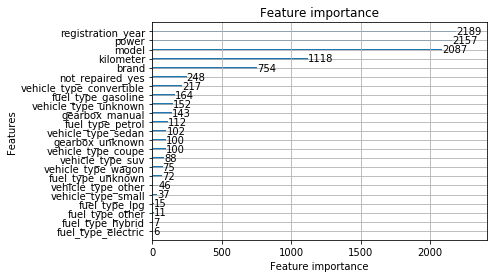

In [92]:
lgb.plot_importance(model_lgbm)